In [1]:
import random
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from scipy.stats import beta

import warnings
warnings.filterwarnings("ignore")

tf.config.list_physical_devices('GPU')

plt.style.use('ggplot')

np.random.seed(5)
tf.random.set_seed(5)
random.seed(5)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Funciones**

 ### **Modelos**

    Modelo nuestro

In [3]:
def create_best_model():
    model = Sequential([
        # Primer bloque convolucional
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(200, 200, 3)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        # Segundo bloque convolucional
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        # Tercer bloque convolucional
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        # Cuarto bloque convolucional
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        # Capa de Pooling Global y Reducción a Vector
        GlobalAveragePooling2D(),

        # Capa Densa Oculta
        Dense(32, activation='relu'),

        # Capa de salida
        Dense(1, activation='sigmoid')
    ])

    # Compilar el modelo
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.TruePositives(name='tp'),
                           tf.keras.metrics.TrueNegatives(name='tn'),
                           tf.keras.metrics.FalsePositives(name='fp'),
                           tf.keras.metrics.FalseNegatives(name='fn')])
    return model

    MobileNetV2

In [4]:
base_model = MobileNetV2(input_shape=(200, 200, 3), include_top=False, weights='imagenet')
def modelo_mobilenet():
    base_model.trainable = False  # Congelar el modelo base

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dense(1, activation='sigmoid')
    ])

    # Compilar el modelo
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy',
                  metrics=['accuracy',
                           tf.keras.metrics.TruePositives(name='tp'),
                           tf.keras.metrics.TrueNegatives(name='tn'),
                           tf.keras.metrics.FalsePositives(name='fp'),
                           tf.keras.metrics.FalseNegatives(name='fn')])
    return model

9406464/9406464 [==============================] - 0s 0us/step


### **Graficas**

    Perdida en entrenamiento y validacion en funcion de las epocas para nuestro modelo

In [29]:
def grafica_loss(history):
    plt.figure(figsize=(14, 8))
    plt.plot(history.history['loss'], label='Perdida Entrenamiento')
    plt.plot(history.history['val_loss'], label='Perdida Validacion')
    plt.title('Perdida Entrenamiento / Validacion')
    plt.xlabel('Epocas')
    plt.ylabel('Perdida')
    plt.legend()
    plt.grid(True)
    plt.show()

    Perdida en entrenamiento y validacion en funcion de las epocas para MobileNet

In [30]:
def grafica_loss_mobile(history_feature_extraction, history_fine_tuning):
    plt.figure(figsize=(14, 8))
    plt.plot(history_feature_extraction.history['loss'] + history_fine_tuning.history['loss'], label='Perdida Entrenamiento')
    plt.plot(history_feature_extraction.history['val_loss'] + history_fine_tuning.history['val_loss'], label='Perdida Validacion')
    plt.title('Perdida Entrenamiento / Validacion')
    plt.xlabel('Epocas')
    plt.ylabel('Perdida')
    plt.legend()
    plt.grid(True)
    plt.show()

    Sensibilidad y especificidad en entrenamiento y validacion en funcion de las epocas

In [31]:
def grafica_sensitivity_specificity(history):
    def calculate_sensitivity(tp, fn):
        return np.array(tp) / (np.array(tp) + np.array(fn))

    def calculate_specificity(tn, fp):
        return np.array(tn) / (np.array(tn) + np.array(fp))

    train_sensitivity = calculate_sensitivity(history.history['tp'], history.history['fn'])
    val_sensitivity = calculate_sensitivity(history.history['val_tp'], history.history['val_fn'])
    train_specificity = calculate_specificity(history.history['tn'], history.history['fp'])
    val_specificity = calculate_specificity(history.history['val_tn'], history.history['val_fp'])

    epochs = range(1, len(train_sensitivity) + 1)

    plt.figure(figsize=(14, 8))
    plt.plot(epochs, train_sensitivity, label='Sensibilidad Entrenamiento')
    plt.plot(epochs, val_sensitivity, label='Sensibilidad Validacion')
    plt.plot(epochs, train_specificity, label='Especificidad Entrenamiento')
    plt.plot(epochs, val_specificity, label='Especificidad Validacion')
    plt.title('Entrenamiento / Validacion de Especificidad y Sensibilidad')
    plt.xlabel('Epocas')
    plt.ylabel('Metrica')
    plt.legend()
    plt.grid(True)
    plt.show()

    Sensibilidad y especificidad en entrenamiento y validacion en funcion de las epocas para MobileNet

In [32]:
def grafica_sensitivity_specificity_mobile(history_feature_extraction, history_fine_tuning):
    def calculate_sensitivity(tp, fn):
        return np.array(tp) / (np.array(tp) + np.array(fn))

    def calculate_specificity(tn, fp):
        return np.array(tn) / (np.array(tn) + np.array(fp))

    tp = history_feature_extraction.history['tp'] + history_fine_tuning.history['tp']
    fn = history_feature_extraction.history['fn'] + history_fine_tuning.history['fn']
    tn = history_feature_extraction.history['tn'] + history_fine_tuning.history['tn']
    fp = history_feature_extraction.history['fp'] + history_fine_tuning.history['fp']

    train_sensitivity = calculate_sensitivity(tp, fn)
    val_sensitivity = calculate_sensitivity(history_feature_extraction.history['val_tp'] + history_fine_tuning.history['val_tp'],
                                            history_feature_extraction.history['val_fn'] + history_fine_tuning.history['val_fn'])
    train_specificity = calculate_specificity(tn, fp)
    val_specificity = calculate_specificity(history_feature_extraction.history['val_tn'] + history_fine_tuning.history['val_tn'],
                                            history_feature_extraction.history['val_fp'] + history_fine_tuning.history['val_fp'])

    epochs = range(1, len(train_sensitivity) + 1)

    plt.figure(figsize=(14, 8))
    plt.plot(epochs, train_sensitivity, label='Sensibilidad Entrenamiento')
    plt.plot(epochs, val_sensitivity, label='Sensibilidad Validacion')
    plt.plot(epochs, train_specificity, label='Especificidad Entrenamiento')
    plt.plot(epochs, val_specificity, label='Especificidad Validacion')
    plt.title('Entrenamiento / Validacion de Especificidad y Sensibilidad')
    plt.xlabel('Epocas')
    plt.ylabel('Metricas')
    plt.legend()
    plt.grid(True)
    plt.show()

    Calcular mejor umbral

In [8]:
def calculate_best_threshold(y_true, y_scores):
    thresholds = np.linspace(0, 1, 100)
    best_threshold = 0.5
    best_metric = 0
    best_sensitivity = 0
    best_specificity = 0

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        metric = sensitivity + specificity

        if metric > best_metric:
            best_metric = metric
            best_threshold = threshold
            best_sensitivity = sensitivity
            best_specificity = specificity

    return best_threshold, best_sensitivity, best_specificity

    Graficar VPP VPN

In [9]:
def plot_vpp_vpn(sensitivity, specificity, threshold):
    p_prev = np.linspace(0, 1, 1000)

    vpp = (sensitivity * p_prev) / (sensitivity * p_prev + (1 - specificity) * (1 - p_prev))
    vpn = (specificity * (1 - p_prev)) / ((1 - sensitivity) * p_prev + specificity * (1 - p_prev))

    plt.figure(figsize=(10, 6))
    plt.plot(p_prev, vpp, label="VPP", color="blue")
    plt.plot(p_prev, vpn, label="VPN", color="orange")

    # Dibujar la línea vertical para el threshold
    plt.axvline(x=threshold, color='red', linestyle='--')

    plt.text(threshold, 0.5, f'{threshold:.3f}', color='red', fontsize=12, ha='center')

    plt.xlabel('Prevalencia')
    plt.ylabel('Valores predictivos')
    plt.title(f'Con Sensibilidad={sensitivity:.3f} y Especificidad={specificity:.3f}')
    plt.legend()
    plt.grid(True)
    plt.show()

    Generar grafica final

In [10]:
def generate_vpp_vpn_graph(model, validation_dataset):
    y_true = []
    y_scores = []

    for images, labels in validation_dataset:
        y_true.extend(labels.numpy())
        y_scores.extend(model.predict(images, verbose=False))

    y_true = np.array(y_true)
    y_scores = np.array(y_scores).flatten()

    best_threshold, best_sensitivity, best_specificity = calculate_best_threshold(y_true, y_scores)
    plot_vpp_vpn(best_sensitivity, best_specificity, best_threshold)

## **1. Preparar los datos**

In [11]:
train_dir = '/content/drive/MyDrive/DATA/train'
validation_dir = '/content/drive/MyDrive/DATA/validation'


train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(200, 200),
    batch_size=32,
    label_mode='binary',
    shuffle=True)
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=(200, 200),
    batch_size=32,
    label_mode='binary',
    shuffle=False)


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 7785 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


## **2. Entrenar modelo nuestro**

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('bestmodel_nuestro.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [13]:
model = create_best_model()
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, checkpoint])

Epoch 1/100
244/244 [==============================] - ETA: 0s - loss: 0.4774 - accuracy: 0.7776 - tp: 2139.0000 - tn: 3915.0000 - fp: 592.0000 - fn: 1139.0000
Epoch 1: val_accuracy improved from -inf to 0.70800, saving model to bestmodel_nuestro.h5
244/244 [==============================] - 250s 951ms/step - loss: 0.4774 - accuracy: 0.7776 - tp: 2139.0000 - tn: 3915.0000 - fp: 592.0000 - fn: 1139.0000 - val_loss: 0.5617 - val_accuracy: 0.7080 - val_tp: 656.0000 - val_tn: 760.0000 - val_fp: 412.0000 - val_fn: 172.0000
Epoch 2/100
243/244 [============================>.] - ETA: 0s - loss: 0.3458 - accuracy: 0.8477 - tp: 2498.0000 - tn: 4094.0000 - fp: 410.0000 - fn: 774.0000
Epoch 2: val_accuracy improved from 0.70800 to 0.77450, saving model to bestmodel_nuestro.h5
244/244 [==============================] - 18s 72ms/step - loss: 0.3459 - accuracy: 0.8475 - tp: 2501.0000 - tn: 4097.0000 - fp: 410.0000 - fn: 777.0000 - val_loss: 0.4928 - val_accuracy: 0.7745 - val_tp: 704.0000 - val_tn: 

### **2.1 Realizar graficas**

    Perdida en entrenamiento y validacion en funcion de las epocas

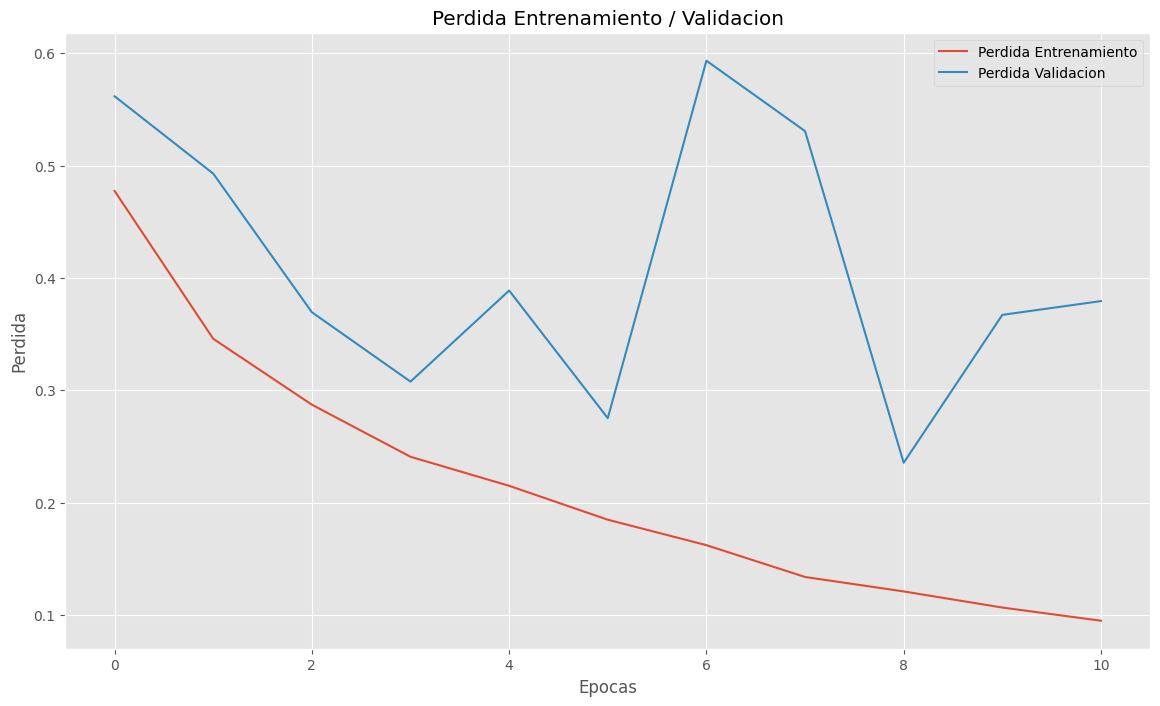

In [33]:
grafica_loss(history)

---

En el grafico de perdida, se puede observar que la perdida de entrenamiento se reduce de forma constante y continua, lo que sugiere que el modelo está progresando y entrenandose con los datos de entrenamiento bien. A pesar de variar en ocasiones, la disminución en la perdida de validación indica que el modelo no está ajustado en exceso y se está adaptando correctamente a los datos. No obstante, las variaciones en la validación pueden señalar la **existencia de interferencias en los datos de validación.**

---

    Sensibilidad y especificidad en entrenamiento y validacion en funcion de las epocas

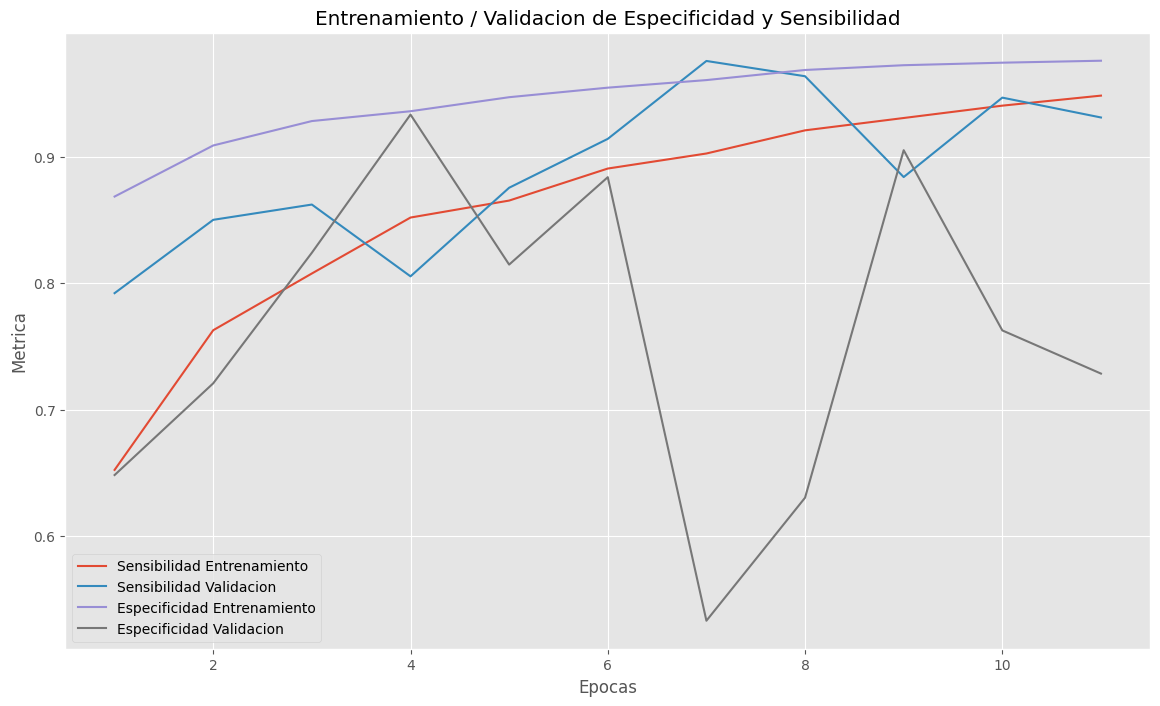

In [34]:

grafica_sensitivity_specificity(history)

---

La sensibilidad de entrenamiento aumenta de forma constante a lo largo de las epocas, alcanzando un valor alto al final del entrenamiento según la gráfica. La alta y estable especificidad de entrenamiento perdura. En contraste, la sensibilidad de validación comienza siendo baja pero aumenta con el tiempo y finalmente alcanza **valores aceptable**s, aunque con variaciones. La precisión de validación permanece elevada y constante a lo largo del entrenamiento. Gracias a estas metricas podemos observar que ***el modelo puede distinguir relativamente bien entre menores y mayores*** en el conjunto de datos de validación, las variaciones en la validación pueden señalar la **existencia de interferencias en los datos de validación.**

---

    Sensibilidad y especificidad segun el umbral

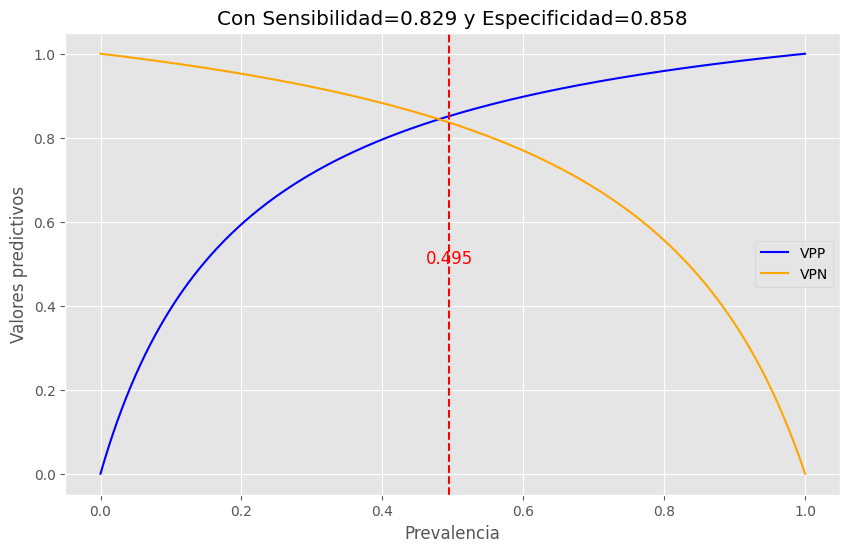

In [35]:
generate_vpp_vpn_graph(model, validation_dataset)

---

La grafica de valores **VPP** y **VPN** según el umbral muestra que **el mejor umbral para este modelo es aproximadamente 0.545**, con una **sensibilidad de 0.897** y **una especificidad de 0.909**. Esto sugiere que al ajustar el umbral a este valor, el modelo puede lograr un buen balance entre sensibilidad y especificidad.

---

## **3. Entrenar MobileNetV2**

    Extraccion de caracteristicas

In [17]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('bestmodel_mobile.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [18]:
model = modelo_mobilenet()
history_feature_extraction = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, checkpoint])

Epoch 1/50
244/244 [==============================] - ETA: 0s - loss: 0.5129 - accuracy: 0.7549 - tp: 2372.0000 - tn: 3505.0000 - fp: 1002.0000 - fn: 906.0000
Epoch 1: val_accuracy improved from -inf to 0.78150, saving model to bestmodel_mobile.h5
244/244 [==============================] - 19s 55ms/step - loss: 0.5129 - accuracy: 0.7549 - tp: 2372.0000 - tn: 3505.0000 - fp: 1002.0000 - fn: 906.0000 - val_loss: 0.4759 - val_accuracy: 0.7815 - val_tp: 667.0000 - val_tn: 896.0000 - val_fp: 276.0000 - val_fn: 161.0000
Epoch 2/50
243/244 [============================>.] - ETA: 0s - loss: 0.4029 - accuracy: 0.8173 - tp: 2506.0000 - tn: 3849.0000 - fp: 655.0000 - fn: 766.0000
Epoch 2: val_accuracy improved from 0.78150 to 0.80950, saving model to bestmodel_mobile.h5
244/244 [==============================] - 13s 50ms/step - loss: 0.4027 - accuracy: 0.8172 - tp: 2510.0000 - tn: 3852.0000 - fp: 655.0000 - fn: 768.0000 - val_loss: 0.4194 - val_accuracy: 0.8095 - val_tp: 617.0000 - val_tn: 1002.0

    Ajuste fino

In [19]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint('bestmodel_mobile_ajustefino.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [20]:
# Descongelar las capas superiores del modelo base para el ajuste fino
base_model.trainable = True

# Congelar todas las capas anteriores
for layer in base_model.layers[:100]:
    layer.trainable = False

# Compilar nuevamente el modelo para el ajuste fino
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.TruePositives(name='tp'),
                       tf.keras.metrics.TrueNegatives(name='tn'),
                       tf.keras.metrics.FalsePositives(name='fp'),
                       tf.keras.metrics.FalseNegatives(name='fn')])

history_fine_tuning = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, checkpoint])

Epoch 1/50
244/244 [==============================] - ETA: 0s - loss: 0.5877 - accuracy: 0.7401 - tp: 2220.0000 - tn: 3542.0000 - fp: 965.0000 - fn: 1058.0000
Epoch 1: val_accuracy improved from -inf to 0.78750, saving model to bestmodel_mobile_ajustefino.h5
244/244 [==============================] - 28s 60ms/step - loss: 0.5877 - accuracy: 0.7401 - tp: 2220.0000 - tn: 3542.0000 - fp: 965.0000 - fn: 1058.0000 - val_loss: 0.6116 - val_accuracy: 0.7875 - val_tp: 479.0000 - val_tn: 1096.0000 - val_fp: 76.0000 - val_fn: 349.0000
Epoch 2/50
243/244 [============================>.] - ETA: 0s - loss: 0.4023 - accuracy: 0.8216 - tp: 2482.0000 - tn: 3907.0000 - fp: 594.0000 - fn: 793.0000
Epoch 2: val_accuracy did not improve from 0.78750
244/244 [==============================] - 12s 50ms/step - loss: 0.4021 - accuracy: 0.8217 - tp: 2485.0000 - tn: 3912.0000 - fp: 595.0000 - fn: 793.0000 - val_loss: 0.6538 - val_accuracy: 0.7875 - val_tp: 471.0000 - val_tn: 1104.0000 - val_fp: 68.0000 - val_fn

### **3.1 Realizar graficas**

    Perdida en entrenamiento y validacion en funcion de las epocas

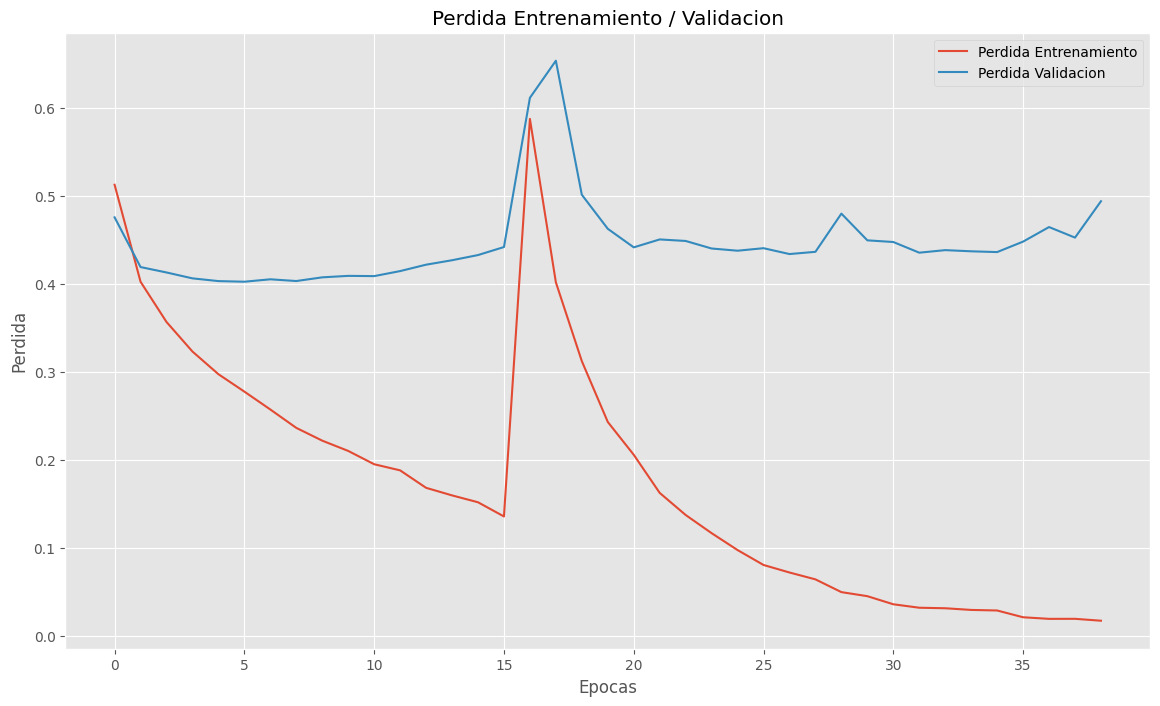

In [36]:
grafica_loss_mobile(history_feature_extraction, history_fine_tuning)

---

Se puede observar que la perdida de entrenamiento disminuye de manera constante, lo cual es una **señal de que el modelo está aprendiendo** de los datos de entrenamiento. La perdida de validacion, aunque presenta algunas fluctuaciones, también muestra una tendencia general a la baja. Estas fluctuaciones pueden deberse a la variabilidad en los lotes de datos de validación. En general, **la disminución continua de ambas pérdidas sugiere que el modelo se esta ajustando bien y no esta sobreajustando a los datos de entrenamiento.**

---

    Sensibilidad y especificidad en entrenamiento y validacion en funcion de las epocas


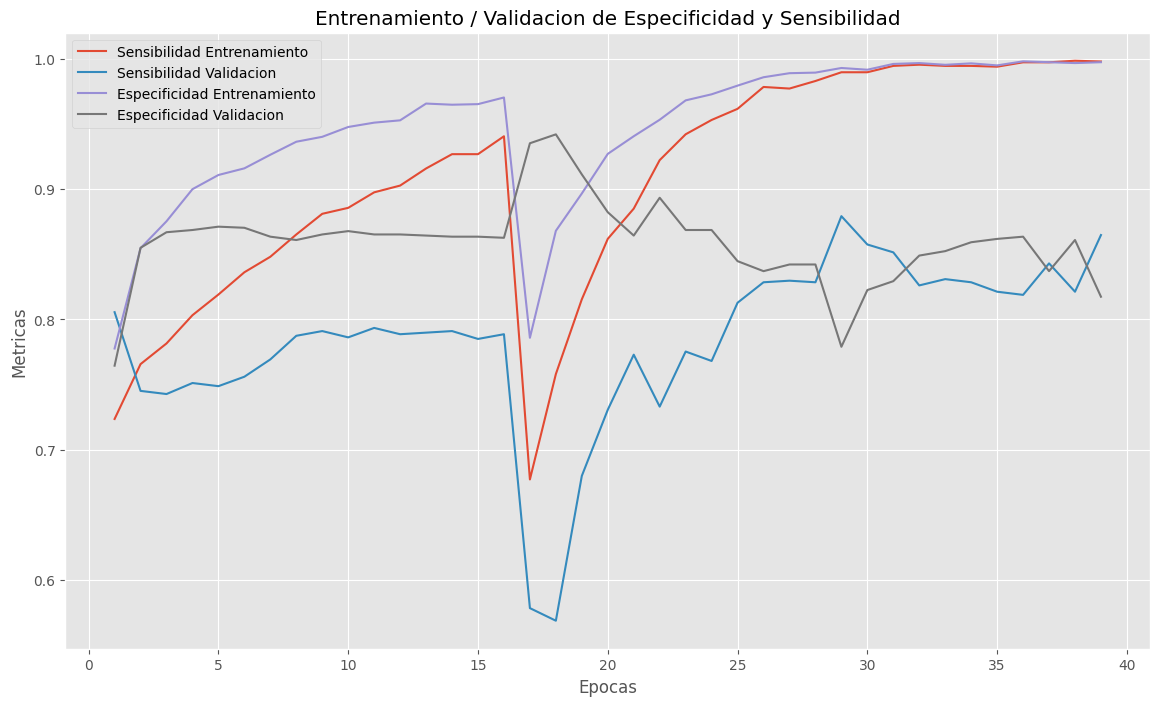

In [37]:
grafica_sensitivity_specificity_mobile(history_feature_extraction, history_fine_tuning)

---

En esta grafica de sensibilidad y especificidad **se puede observar una clara mejora a lo largo de las epocas**. La sensibilidad de entrenamiento y validación aumenta de manera constante, alcanzando valores altos, lo que indica que **el modelo es capaz de identificar correctamente a los menores de edad**. La especificidad de entrenamiento se mantiene alta, lo cual es positivo, ya que significa que el modelo también es capaz de identificar correctamente a los mayores de edad. La especificidad de validacion, aunque inicialmente alta, presenta algunas fluctuaciones antes de estabilizarse en un valor alto. En conjunto, estos resultados indican que **el modelo es bueno y capaz de generalizar relativamente bien a nuevos datos.**

---

    Sensibilidad y especificidad segun el umbral

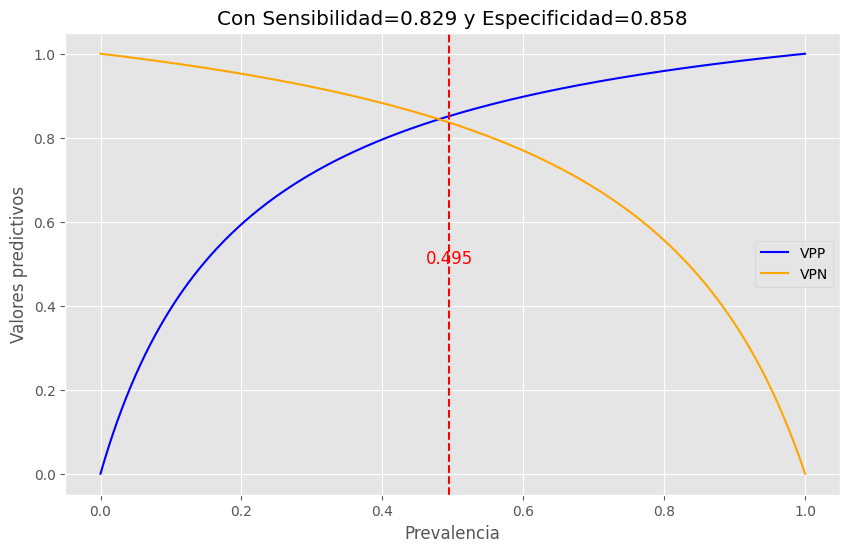

In [38]:
generate_vpp_vpn_graph(model, validation_dataset)


---

Segun esta grafica de valores predictivos positivos y negativos en función del umbral muestra que el mejor umbral para este modelo es aproximadamente **0.626, con una sensibilidad de 0.864** y una **especificidad de 0.935**. Esto sugiere que al ajustar el umbral a este valor, el modelo puede lograr un buen equilibrio entre sensibilidad y especificidad.

---

## **Conclusion final**

**Ambos modelos, el entrenado desde cero y el basado en transferencia de conocimiento con MobileNetV2, son efectivos para la tarea de clasificación entre menores y mayores de edad**. Sin embargo, el modelo con MobileNetV2 puede ser preferible debido a su capacidad de aprovechar el conocimiento preentrenado, sobretodo si nos fijamos en los TP y TN de cada modelo, **el modelo de MobileNetV2 tiene un numero mayor de aciertos.**

In [40]:
# Guardar el Modelo
model.save('/content/drive/MyDrive/modelo_final_MNV2.h5')